# Phase 1: Projection Profile Method

This notebook implements the Jigsaw Puzzle Solver Phase 1 using the Projection Profile Method.
It covers:
1.  **Preprocessing**: Grayscale conversion and Gaussian Blur.
2.  **Edge Enhancement**: Laplacian filter to highlight cuts.
3.  **Projection Analysis**: Summing edge energy to find grid lines.
4.  **Segmentation**: Cutting the image into pieces.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

def show_image(img, title="Image", cmap=None):
    plt.figure(figsize=(8, 8))
    if len(img.shape) == 3:
        # Convert BGR to RGB for correct display involved in cv2.imread
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

## 1. Load Image

Loaded image: Jigsaw Puzzle Dataset/Gravity Falls/puzzle_2x2/0.jpg


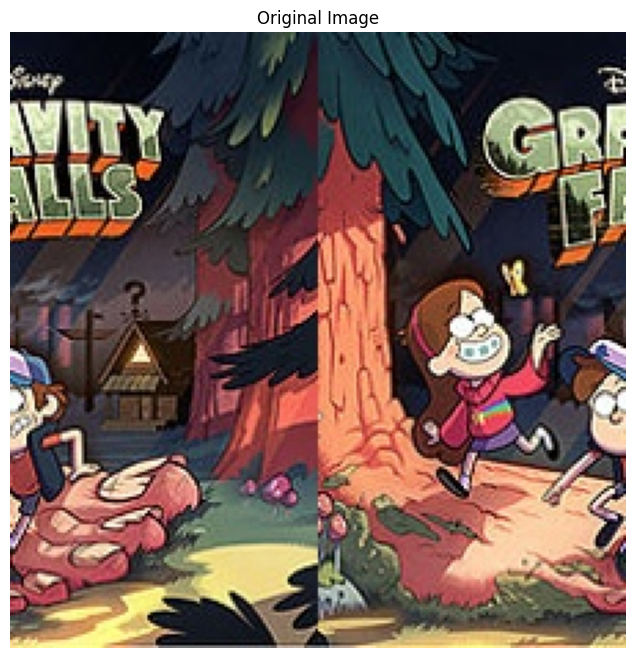

In [2]:
image_path = r"Jigsaw Puzzle Dataset/Gravity Falls/puzzle_2x2/0.jpg"  # Update this path as needed
output_dir = "phase1_output"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

original = cv2.imread(image_path)
if original is None:
    print("Error: Image not found.")
else:
    print(f"Loaded image: {image_path}")
    show_image(original, "Original Image")

## 2. Preprocessing & Noise Attenuation
We convert the image to grayscale and apply a Gaussian Blur to smooth out texture noise, leaving strong structural lines (cuts).

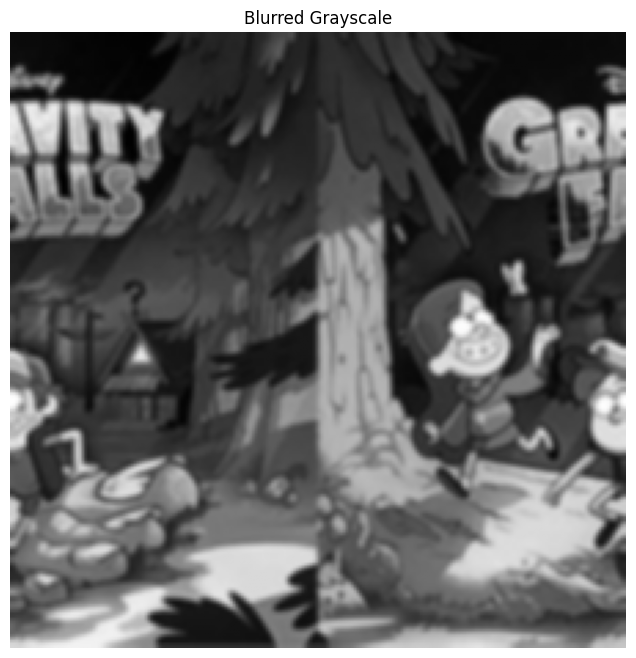

In [3]:
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

show_image(blurred, "Blurred Grayscale", cmap='gray')

## 3. Edge Enhancement
Using the Laplacian filter to detect edges. Finding changes in intensity.

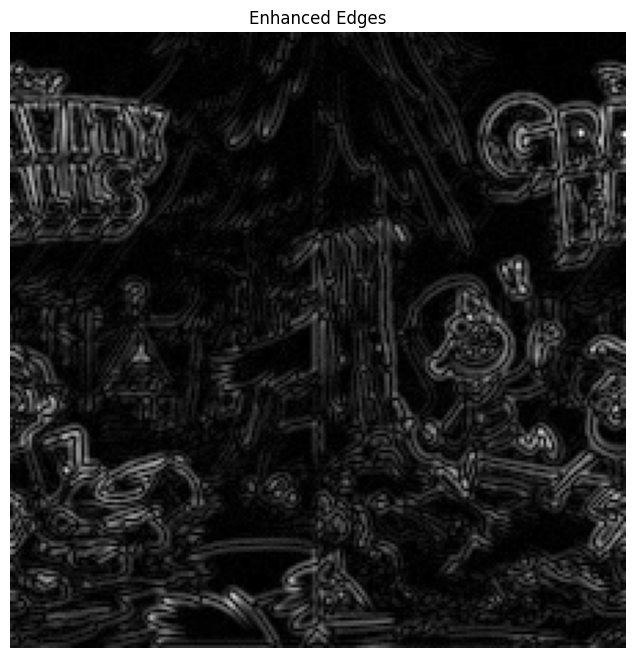

In [4]:
edges = cv2.Laplacian(blurred, cv2.CV_64F)
edges = np.abs(edges)

# Normalize for visualization
edges_vis = cv2.normalize(edges, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
cv2.imwrite(f"{output_dir}/enhanced_edges.jpg", edges_vis)

show_image(edges_vis, "Enhanced Edges", cmap='gray')

## 4. Projection Analysis
Summing the edge energy along the X and Y axes to find the cut lines.

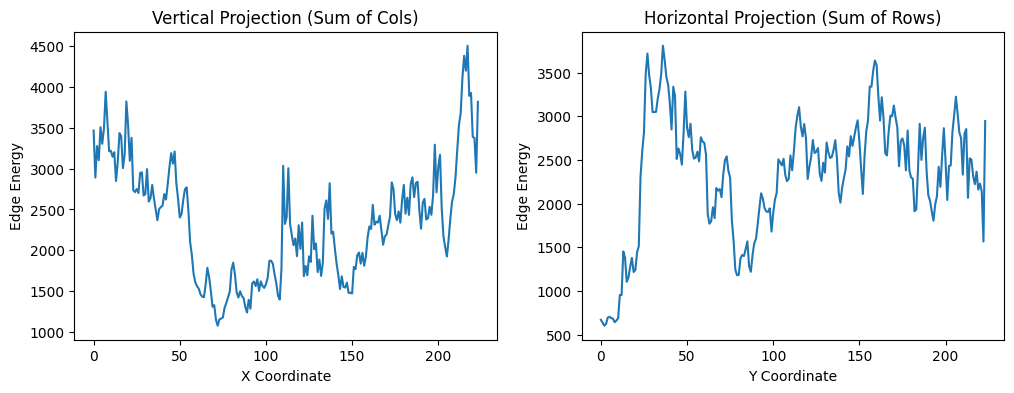

In [5]:
vertical_projection = np.sum(edges, axis=0)
horizontal_projection = np.sum(edges, axis=1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(vertical_projection)
plt.title("Vertical Projection (Sum of Cols)")
plt.xlabel("X Coordinate")
plt.ylabel("Edge Energy")

plt.subplot(1, 2, 2)
plt.plot(horizontal_projection)
plt.title("Horizontal Projection (Sum of Rows)")
plt.xlabel("Y Coordinate")
plt.ylabel("Edge Energy")
plt.show()

## 5. Peak Finding (Grid Detection)
Identifying the grid size (N) and the cut coordinates based on the projection peaks.

In [6]:
h, w = gray.shape

def find_cuts(projection, length, min_pieces=2, max_pieces=8):
    proj = projection.flatten()
    best_N = 2
    best_score = -1
    
    for N in [2, 4, 8]:
        score = 0
        step = length / N
        for i in range(1, N):
            target_idx = int(i * step)
            start_win = max(0, target_idx-5)
            end_win = min(len(proj), target_idx+5)
            window = proj[start_win:end_win]
            if len(window) > 0:
                score += np.max(window)
        
        # Normalize score
        if (N - 1) > 0:
            normalized_score = score / (N - 1)
        else:
            normalized_score = 0
            
        if normalized_score > best_score:
            best_score = normalized_score
            best_N = N
            
    cuts = []
    step = length / best_N
    for i in range(1, best_N):
        target_idx = int(i * step)
        start_win = max(0, target_idx-10)
        end_win = min(len(proj), target_idx+10)
        window = proj[start_win:end_win]
        if len(window) > 0:
            local_max = np.argmax(window)
            cuts.append(start_win + local_max)
        else:
            cuts.append(target_idx)
            
    return cuts, best_N

x_cuts, N_x = find_cuts(vertical_projection, w)
y_cuts, N_y = find_cuts(horizontal_projection, h)

final_N = max(N_x, N_y)
print(f"Detected Grid: {final_N}x{final_N}")
print(f"X Cuts: {x_cuts}")
print(f"Y Cuts: {y_cuts}")

Detected Grid: 2x2
X Cuts: [np.int64(110)]
Y Cuts: [np.int64(115)]


## 6. Artifact Visualizaton
Overlaying the detected grid on the original image.

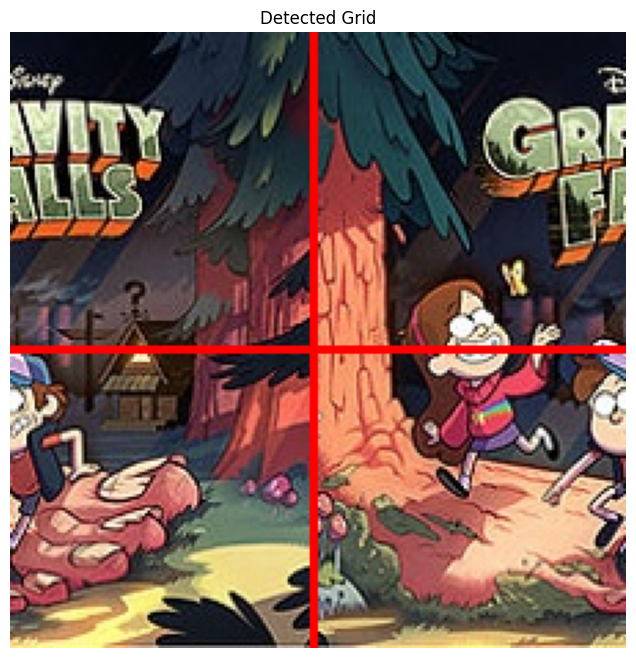

In [7]:
mask_vis = original.copy()
for x in x_cuts:
    cv2.line(mask_vis, (x, 0), (x, h), (0, 0, 255), 2)
for y in y_cuts:
    cv2.line(mask_vis, (0, y), (w, y), (0, 0, 255), 2)

cv2.imwrite(f"{output_dir}/detected_grid.jpg", mask_vis)
show_image(mask_vis, "Detected Grid")

## 7. Saving Pieces
Slicing the image and saving individual pieces.

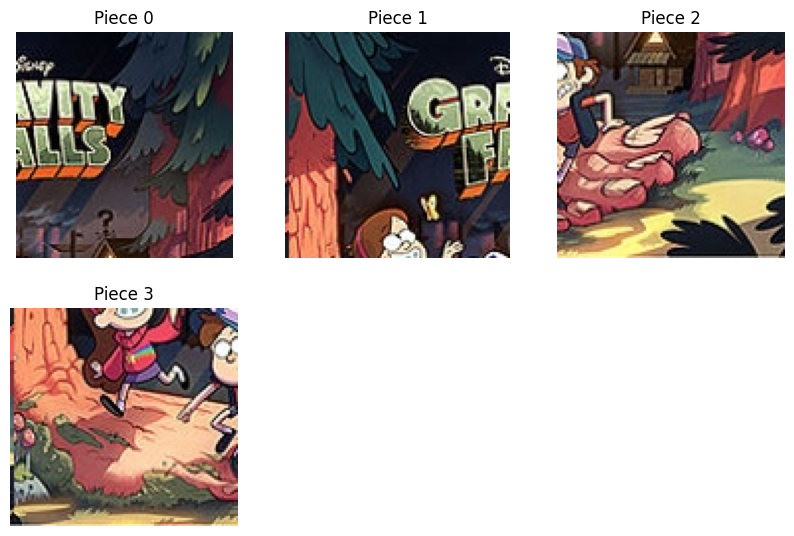

Saved 4 pieces to phase1_output/


In [8]:
piece_idx = 0
x_bounds = [0] + x_cuts + [w]
y_bounds = [0] + y_cuts + [h]
x_bounds.sort()
y_bounds.sort()

# Visualize first few pieces inline
plt.figure(figsize=(10, 10))

for i in range(len(y_bounds)-1):
    for j in range(len(x_bounds)-1):
        y1, y2 = y_bounds[i], y_bounds[i+1]
        x1, x2 = x_bounds[j], x_bounds[j+1]
        
        if x2 > x1 and y2 > y1:
            piece = original[y1:y2, x1:x2]
            cv2.imwrite(f"{output_dir}/piece_{piece_idx}.jpg", piece)
            
            if piece_idx < 9: # Show only first 9 pieces inline
                plt.subplot(3, 3, piece_idx + 1)
                plt.imshow(cv2.cvtColor(piece, cv2.COLOR_BGR2RGB))
                plt.title(f"Piece {piece_idx}")
                plt.axis('off')
            
            piece_idx += 1
plt.show()
print(f"Saved {piece_idx} pieces to {output_dir}/")